# Projecting Future MLB Hall-of-Famers and Undervalued Rookie Cards

Business problem: FanDuel, a popular sports betting site, is interested in capitalizing on the recent sports card boom and wants to implement a paid tool to provide sports card investment advice. While young stars (under 25 yrs old) have been the hottest part of the market, recently legends and Hall-of-Famers have also seen increases in card prices. This provides an excellent investment opportunity in the middle group: proven veterans who are on track to make the Hall of Fame. FanDuel is interested in a tool that can identify Hall of Fame worthy players to invest and provide advice to clients early.  

* This project will be following the OSEMN data-science process

## Goal

The goal of this project is to develop a methodology that predicts future hall-of-famers, identify the undervalued rookie cards from this group, and provide estiamations of how that card might increase by comparing them to rookie cards of hall-of-famers with similar statistics.

For this particular run, the goal is to provide **3** player recommendations who might be good longterm investments based on their current prices and their projected prices, if their careers progress as expected.

# Obtain Data

In [2]:
import pandas as pd
pd.set_option('display.max_columns', 50)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Import all batting statistics. The data is broken up into Hall-of-Famers, Retired Non-Hall-of-Fame/Former All-Stars, and Active All-Stars. 

The last dataset includes every era in MLB history, with start and end years. For this one, actual MLB "eras" stopped being recorded after the Expansion era, which ended in 1973. Thus, I added makeshift eras, one between 1974 and the 21st century and one from 2000 until present 2020.

- https://stathead.com/tiny/O0i63 Hall of Fame data link
- https://stathead.com/tiny/4lBX0 Retired All Stars data link
- https://stathead.com/tiny/QsiK8 Active All Stars data link

In [62]:
hof_df = pd.read_csv('data/hof_stats.csv') # Hall-of-Fame
non_hof_df = pd.read_csv('data/retired_non_hof.csv') # Retired (non-HOF, former AS)
active_df = pd.read_csv('data/active_allstars.csv') # Active All-Stars

eras_df = pd.read_csv('data/mlb_history_eras.csv') # All eras in MLB history

datasets = [hof_df, non_hof_df, active_df]

In [63]:
hof_df.shape

(190, 31)

In [60]:
non_hof_df.shape

(775, 31)

In [61]:
active_df.shape

(138, 31)

In [4]:
eras_df

,Era,Start,End
0,19th Century,1846,1900
1,Dead Ball,1901,1919
2,Lively Ball,1920,1945
3,Post-War,1946,1960
4,Expansion,1961,1973
5,Pre-2000s,1974,1999
6,21st Century,2000,2020


In [5]:
hof_df.head()

,Rk,Player,WAR/pos,WAA/pos,From,To,Age,G,PA,AB,R,H,2B,3B,HR,RBI,BB,IBB,SO,HBP,SH,SF,GDP,SB,CS,BA,OBP,SLG,OPS,Pos,Tm
0,1,Hank Aaron\aaronha01,143.1,93.0,1954,1976,20-42,3298,13941,12364,2174,3771,624,98,755,2297,1402,293.0,1383,32,21.0,121.0,328.0,240,73.0,0.305,0.374,0.555,0.928,*9783DH/45,MLN-ATL-MIL
1,2,Pete Alexander\alexape01,3.0,3.0,1911,1930,24-43,703,1981,1810,154,378,60,13,11,163,77,NaN,276,2,88.0,NaN,NaN,3,5.0,0.209,0.242,0.275,0.517,*1/H7,PHI-CHC-STL
2,3,Roberto Alomar\alomaro01,67.0,32.5,1988,2004,20-36,2379,10400,9073,1508,2724,504,80,210,1134,1032,62.0,1140,50,148.0,97.0,206.0,474,114.0,0.300,0.371,0.443,0.814,*4/HD6,SDP-TOR-BAL-CLE-NYM-CHW-ARI
3,4,Cap Anson\ansonca01,94.4,55.4,1871,1897,19-45,2524,11331,10281,1999,3435,582,142,97,2075,984,NaN,330,32,34.0,NaN,6.0,277,16.0,0.334,0.394,0.447,0.841,*352/794681,ROK-ATH-CHC
4,5,Luis Aparicio\aparilu01,55.9,20.5,1956,1973,22-39,2599,11231,10230,1335,2677,394,92,83,791,736,22.0,742,27,161.0,76.0,184.0,506,136.0,0.262,0.311,0.343,0.653,*6/H,CHW-BAL-BOS


In [6]:
hof_df.describe()

,Rk,WAR/pos,WAA/pos,From,To,G,PA,AB,R,H,2B,3B,HR,RBI,BB,IBB,SO,HBP,SH,SF,GDP,SB,CS,BA,OBP,SLG,OPS
count,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,106.000000,190.000000,190.000000,185.000000,81.000000,125.000000,190.000000,160.000000,190.000000,190.000000,190.000000,190.000000
mean,95.500000,57.353158,31.218421,1933.126316,1950.505263,1925.857895,8012.626316,7049.752632,1162.378947,2111.336842,363.789474,90.531579,194.868421,1073.047368,791.331579,99.386792,714.815789,49.168421,91.675676,67.345679,144.872000,194.010526,58.193750,0.285974,0.354111,0.433484,0.787558
std,54.992424,33.853192,23.949604,33.977348,34.546303,738.253965,3326.660076,2900.178704,535.246236,923.957569,173.878745,62.180966,182.694583,528.620550,468.344897,78.272609,513.857280,45.149523,88.270599,37.335359,98.093518,218.550734,54.778743,0.049478,0.064122,0.101134,0.160052
min,1.000000,-3.800000,-4.000000,1871.000000,1890.000000,23.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.250000,42.450000,16.950000,1905.250000,1925.250000,1561.500000,6517.000000,5825.750000,915.250000,1705.750000,270.750000,47.000000,40.500000,790.250000,489.500000,33.000000,302.250000,20.000000,20.000000,45.000000,55.000000,34.250000,16.000000,0.271250,0.342000,0.387500,0.747000
50%,95.500000,56.450000,28.350000,1928.000000,1946.500000,2078.000000,8686.500000,7731.000000,1252.500000,2303.500000,387.000000,77.500000,127.000000,1127.000000,768.500000,87.500000,550.500000,39.000000,59.000000,74.000000,155.000000,113.000000,46.000000,0.296500,0.368500,0.449500,0.817500
75%,142.750000,72.850000,39.750000,1961.000000,1979.750000,2439.750000,10275.250000,9097.750000,1541.750000,2730.500000,486.000000,136.750000,310.500000,1437.500000,1055.500000,154.750000,1014.000000,66.750000,147.000000,97.000000,217.000000,287.500000,80.750000,0.316000,0.391000,0.499750,0.881750
max,190.000000,162.100000,125.500000,1996.000000,2014.000000,3308.000000,13992.000000,12364.000000,2295.000000,4189.000000,792.000000,309.000000,755.000000,2297.000000,2190.000000,298.000000,2597.000000,287.000000,512.000000,128.000000,350.000000,1406.000000,335.000000,0.366000,0.482000,0.690000,1.164000


In [7]:
# total number of players 
print(len(hof_df) + len(non_hof_df) + len(active_df))

1103


This is a list of desriptions for each column name:

## Column Names and descriptions for batting stats
* **Player** - player first and last name
* **WAR/pos** - Wins Above Replacement for position players. A singular number that represents the number of wins a player adds to a team over a replacement.
* **WAA/pos** - Wins Above Average for position players. A singular number that represents the number of wins a player adds to a team over a league-average player.
* **From** -  year player's career began
* **To** -  year player's career ended
* **Age** -  age of career beginning/end on June 30 of the respective year
* **G** -  number of games player
* **PA** -  plate appearances
* **AB** -  at-bats
* **R** - runs scored
* **H** - hits
* **2B** - doubles
* **3B** - triples
* **HR** - home-runs
* **RBI** - runs batted in
* **BB** - walks
* **IBB** - intentional walks
* **SO** - strikeouts
* **HBP** - times hit by pitch
* **SH** - sacrifice hits (sacrifice bunts)
* **SF** - sacrifice flies
* **GDP** - double plays grounded into
* **SB** - stolen bases
* **CS** - number of times caught stealing
* **BA** - batting average
* **OBP** - on-base percentage
* **SLG** - slugging percentage
* **OPS** - on-base + slugging percentages
* **Pos** - All positions a player has played. Over 300 games denoted by * and less than 30 games denoted by /
* **Tm** - All teams a player has played on.
* **HOF** - indicates whether a player is in the hall-of-fame

The descriptions can also be found in 'data/batting_col_descriptions.md'

# Scrub Data

The first thing to do is add a column in each batting stats dataset that indicates whether a player is in the HOF.

In [8]:
# all players in hof_df are, by definition, in the HOF. So mark each player with a 1.
hof_df['HOF'] = 1

In [9]:
# all players in the other two datasets are not in the HOF. So mark each player with a 0.
non_hof_df['HOF'] = 0
active_df['HOF'] = 0

Next, I want to delete 'Rk' column as it is just another index. Then, I want to reorder the columns in a way that makes sense and make sure that each dataset has columns in the same order.

In [10]:
# establish universal order for columns
neworder = ['Player', 'From', 'To', 'Age', 'G', 'PA', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 
            'BA', 'OBP', 'SLG', 'OPS', 'SB', 'CS', 'BB', 'IBB', 'SO', 'WAR/pos', 'WAA/pos', 
            'HBP', 'SH', 'SF', 'GDP', 'Pos', 'Tm', 'HOF']

hof_df = hof_df.reindex(columns=neworder)
non_hof_df = non_hof_df.reindex(columns=neworder)
active_df = active_df.reindex(columns=neworder)

The next thing to do is to drop any players whose main position was Pitcher. All of these datasets include players who have played at least 1 game at a non-Pitcher position. However, some of these players have played most of their careers at pitcher and may skew the batting statistics (traditionally, pitchers are known to be below-average hitters).

Position is indicated on a 1-9 scale:
1 (pitcher), 2 (catcher), 3 (first baseman), 4 (second baseman), 5 (third baseman), 6 (shortstop), 7 (left fielder) 8 (center fielder), and 9 (right fielder). In the datasets, the position with an * in front of it is considered a player's main position (i.e. where he played the most games). So any player with a 1 following the asterisk is a pitcher.

In [11]:
# player at index 1 is a pitcher
hof_df['Pos']

0       *9783DH/45
1            *1/H7
2           *4/HD6
3      *352/794681
4             *6/H
          ...     
185      *97D8H/35
186      *73D8/H59
187          *1/3H
188        *9/4H87
189       *68D/7H3
Name: Pos, Length: 190, dtype: object

In [12]:
# find all pitchers and drop them
index_names = hof_df[hof_df['Pos'].str.contains("\*1")].index
hof_df.drop(index_names, inplace = True)

index_names = non_hof_df[non_hof_df['Pos'].str.contains("\*1")].index
non_hof_df.drop(index_names, inplace = True) 

index_names = active_df[active_df['Pos'].str.contains("\*1")].index
active_df.drop(index_names, inplace = True) 

Another thing we want to do is edit the name column, as currently they show more than just the first and last names.

In [13]:
hof_df['Player']

0            Hank Aaron\aaronha01
2        Roberto Alomar\alomaro01
3             Cap Anson\ansonca01
4         Luis Aparicio\aparilu01
5          Luke Appling\applilu01
                  ...            
184         Hack Wilson\wilsoha01
185       Dave Winfield\winfida01
186    Carl Yastrzemski\yastrca01
188         Ross Youngs\youngro01
189         Robin Yount\yountro01
Name: Player, Length: 162, dtype: object

In [14]:
# Clean names of each player in each dataset
hof_df['Player'] = [name.split('\\', 1)[0] for name in hof_df['Player']]
non_hof_df['Player'] = [name.split('\\', 1)[0] for name in non_hof_df['Player']]
active_df['Player'] = [name.split('\\', 1)[0] for name in active_df['Player']]

In [15]:
hof_df.head()

,Player,From,To,Age,G,PA,AB,R,H,2B,3B,HR,RBI,BA,OBP,SLG,OPS,SB,CS,BB,IBB,SO,WAR/pos,WAA/pos,HBP,SH,SF,GDP,Pos,Tm,HOF
0,Hank Aaron,1954,1976,20-42,3298,13941,12364,2174,3771,624,98,755,2297,0.305,0.374,0.555,0.928,240,73.0,1402,293.0,1383,143.1,93.0,32,21.0,121.0,328.0,*9783DH/45,MLN-ATL-MIL,1
2,Roberto Alomar,1988,2004,20-36,2379,10400,9073,1508,2724,504,80,210,1134,0.300,0.371,0.443,0.814,474,114.0,1032,62.0,1140,67.0,32.5,50,148.0,97.0,206.0,*4/HD6,SDP-TOR-BAL-CLE-NYM-CHW-ARI,1
3,Cap Anson,1871,1897,19-45,2524,11331,10281,1999,3435,582,142,97,2075,0.334,0.394,0.447,0.841,277,16.0,984,NaN,330,94.4,55.4,32,34.0,NaN,6.0,*352/794681,ROK-ATH-CHC,1
4,Luis Aparicio,1956,1973,22-39,2599,11231,10230,1335,2677,394,92,83,791,0.262,0.311,0.343,0.653,506,136.0,736,22.0,742,55.9,20.5,27,161.0,76.0,184.0,*6/H,CHW-BAL-BOS,1
5,Luke Appling,1930,1950,23-43,2422,10254,8856,1319,2749,440,102,45,1116,0.310,0.399,0.398,0.798,179,108.0,1302,33.0,528,77.1,44.1,11,74.0,NaN,129.0,*6/5H43,CHW,1


Check for missing data in all three. Each dataframe has the exact same columns, so whatever changes are made to one, will be made to the others as well.

In [16]:
hof_df.isna().sum() / len(hof_df)

Player     0.000000
From       0.000000
To         0.000000
Age        0.000000
G          0.000000
PA         0.000000
AB         0.000000
R          0.000000
H          0.000000
2B         0.000000
3B         0.000000
HR         0.000000
RBI        0.000000
BA         0.000000
OBP        0.000000
SLG        0.000000
OPS        0.000000
SB         0.000000
CS         0.111111
BB         0.000000
IBB        0.401235
SO         0.000000
WAR/pos    0.000000
WAA/pos    0.000000
HBP        0.000000
SH         0.012346
SF         0.543210
GDP        0.290123
Pos        0.000000
Tm         0.000000
HOF        0.000000
dtype: float64

Seems IBB, SF, SH, GDP, CS all have missing data. Here, the only one that might be useful to keep is IBB because the number of times a player has been intentionally walked could be an indication of how "feared" a hitter was. The reason that IBB is missing for so many players is that IBB was a new stat that was not measured until 1955. For now, we will drop the column but may return to include it.

In [17]:
non_hof_df.isna().sum() / len(non_hof_df)

Player     0.000000
From       0.000000
To         0.000000
Age        0.000000
G          0.000000
PA         0.000000
AB         0.000000
R          0.000000
H          0.000000
2B         0.000000
3B         0.000000
HR         0.000000
RBI        0.000000
BA         0.000000
OBP        0.000000
SLG        0.000000
OPS        0.000000
SB         0.000000
CS         0.005666
BB         0.000000
IBB        0.009915
SO         0.000000
WAR/pos    0.000000
WAA/pos    0.000000
HBP        0.000000
SH         0.000000
SF         0.143059
GDP        0.000000
Pos        0.000000
Tm         0.000000
HOF        0.000000
dtype: float64

Retired Non-Hall-of-Famers have missing values in IBB, SF, CS. All are droppable.

In [18]:
active_df.isna().sum() / len(active_df)

Player     0.0
From       0.0
To         0.0
Age        0.0
G          0.0
PA         0.0
AB         0.0
R          0.0
H          0.0
2B         0.0
3B         0.0
HR         0.0
RBI        0.0
BA         0.0
OBP        0.0
SLG        0.0
OPS        0.0
SB         0.0
CS         0.0
BB         0.0
IBB        0.0
SO         0.0
WAR/pos    0.0
WAA/pos    0.0
HBP        0.0
SH         0.0
SF         0.0
GDP        0.0
Pos        0.0
Tm         0.0
HOF        0.0
dtype: float64

No missing values for Active players.

Drop all columns with missing values. For consistency, any column dropped must be dropped in the other columns as well.

In [19]:
# dropping NA values
hof_df.drop(['IBB', 'SF', 'SH', 'GDP', 'CS'], axis=1, inplace=True)
non_hof_df.drop(['IBB', 'SF', 'SH', 'GDP', 'CS'], axis=1, inplace=True)
active_df.drop(['IBB', 'SF', 'SH', 'GDP', 'CS'], axis=1, inplace=True)

Now we can combine the three dataframes into one large dataframe.

In [20]:
# combine all three datasets into one
all_df = pd.concat([hof_df, non_hof_df, active_df])
all_df['id'] = all_df.reset_index().index

In [21]:
all_df.reset_index(inplace=True)

In [22]:
all_df.drop('index', inplace=True, axis=1)

# Explore Data

In [23]:
all_df.describe()

,From,To,G,PA,AB,R,H,2B,3B,HR,RBI,BA,OBP,SLG,OPS,SB,BB,SO,WAR/pos,WAA/pos,HBP,HOF,id
count,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000
mean,1971.117764,1984.139721,1532.065868,6135.661677,5420.498004,800.871257,1522.303393,274.645709,45.770459,165.848303,760.763473,0.276418,0.349289,0.434297,0.783584,109.972056,590.764471,769.996008,33.126447,12.794711,42.542914,0.161677,500.500000
std,31.240489,29.755051,598.786248,2616.236103,2296.264232,406.521228,708.843363,133.141798,41.177368,126.863827,405.038722,0.022614,0.027925,0.055921,0.074700,140.214924,338.961018,423.169670,23.710726,17.070191,36.411631,0.368338,289.396786
min,1871.000000,1890.000000,123.000000,240.000000,208.000000,43.000000,56.000000,5.000000,0.000000,0.000000,14.000000,0.206000,0.279000,0.280000,0.580000,0.000000,26.000000,23.000000,-0.400000,-5.000000,0.000000,0.000000,0.000000
25%,1949.000000,1962.000000,1112.500000,4274.250000,3783.250000,498.250000,1003.250000,176.250000,19.000000,75.000000,453.250000,0.261000,0.330000,0.396250,0.736000,24.000000,346.250000,438.000000,16.500000,1.200000,19.000000,0.000000,250.250000
50%,1974.000000,1989.000000,1502.000000,5942.000000,5301.000000,744.000000,1459.500000,260.000000,34.000000,131.500000,693.500000,0.275000,0.347000,0.433000,0.782000,58.500000,524.000000,693.500000,27.600000,7.950000,32.000000,0.000000,500.500000
75%,1997.000000,2011.000000,1941.000000,7935.000000,7032.750000,1053.500000,1992.750000,356.000000,59.000000,232.750000,1011.750000,0.290000,0.365750,0.470750,0.827000,137.000000,773.500000,1023.250000,43.900000,19.550000,53.750000,0.000000,750.750000
max,2019.000000,2020.000000,3562.000000,15890.000000,14053.000000,2295.000000,4256.000000,792.000000,309.000000,762.000000,2297.000000,0.366000,0.482000,0.690000,1.164000,1406.000000,2558.000000,2597.000000,162.800000,125.500000,287.000000,1.000000,1001.000000


In [24]:
hof_df.describe()

,From,To,G,PA,AB,R,H,2B,3B,HR,RBI,BA,OBP,SLG,OPS,SB,BB,SO,WAR/pos,WAA/pos,HBP,HOF
count,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.0
mean,1935.975309,1953.691358,2169.098765,9142.160494,8031.543210,1339.425926,2426.154321,419.425926,103.981481,226.962963,1236.308642,0.302278,0.376093,0.464741,0.840796,225.759259,917.030864,796.444444,67.012963,36.400617,56.796296,1.0
std,33.278413,33.456245,477.585961,2043.164422,1788.463292,347.425398,565.730480,119.220804,57.278276,179.252412,380.410538,0.023909,0.030485,0.065348,0.086930,221.745862,386.321069,512.539555,26.545421,22.059092,44.631151,0.0
min,1871.000000,1890.000000,1211.000000,4816.000000,4205.000000,579.000000,1161.000000,178.000000,8.000000,11.000000,530.000000,0.253000,0.299000,0.316000,0.653000,8.000000,308.000000,114.000000,16.200000,0.200000,9.000000,1.0
25%,1913.250000,1930.000000,1808.750000,7624.750000,6708.000000,1103.750000,2057.250000,339.500000,62.500000,75.000000,954.000000,0.284250,0.356000,0.427500,0.796250,67.250000,641.000000,376.250000,49.150000,22.500000,29.250000,1.0
50%,1931.500000,1948.000000,2165.000000,9329.000000,8138.500000,1305.000000,2400.500000,413.500000,88.000000,174.000000,1234.500000,0.303500,0.376000,0.462000,0.835000,153.000000,851.000000,646.000000,63.150000,31.550000,43.500000,1.0
75%,1961.750000,1982.750000,2499.000000,10505.500000,9308.250000,1583.000000,2842.750000,498.000000,145.750000,360.500000,1519.500000,0.318000,0.394750,0.505000,0.888750,334.500000,1105.000000,1193.750000,76.600000,43.700000,74.250000,1.0
max,1996.000000,2014.000000,3308.000000,13992.000000,12364.000000,2295.000000,4189.000000,792.000000,309.000000,755.000000,2297.000000,0.366000,0.482000,0.690000,1.164000,1406.000000,2190.000000,2597.000000,162.100000,125.500000,287.000000,1.0


As expected there is a higher statistical standard for a hall-of-fame player. Some of the most notable statistics, such as H, HR, RBI, BA, WAR/pos, are higher for hall-of-famers across the board. 

In [25]:
all_df.dtypes

Player      object
From         int64
To           int64
Age         object
G            int64
PA           int64
AB           int64
R            int64
H            int64
2B           int64
3B           int64
HR           int64
RBI          int64
BA         float64
OBP        float64
SLG        float64
OPS        float64
SB           int64
BB           int64
SO           int64
WAR/pos    float64
WAA/pos    float64
HBP          int64
Pos         object
Tm          object
HOF          int64
id           int64
dtype: object

From the data types, there are a few that will not be relevant for the modeling stage. Columns like age or team are not relevant when predicting hall-of-fame-type careers. 

Instead of dropping any column that might not be of immediate use for our model, just create a list of all column names that will be used as predictors for the model.

In [26]:
# choose statistics that will be used as predictors
predictors = ['R', 'H', '2B', '3B', 'HR', 'RBI', 'BB', 'SB',
            'BA', 'OBP', 'SLG', 'OPS', 'WAR/pos', 'WAA/pos']

# target column is HOF indicator
target_col = ['HOF']

We can see that all of these are counting stats or measurements. As a result, none of these should be considered to be categorical data, which saves us the step of creating dummy variables.

In [27]:
# predictors used in model
all_df[predictors]

,R,H,2B,3B,HR,RBI,BB,SB,BA,OBP,SLG,OPS,WAR/pos,WAA/pos
0,2174,3771,624,98,755,2297,1402,240,0.305,0.374,0.555,0.928,143.1,93.0
1,1508,2724,504,80,210,1134,1032,474,0.300,0.371,0.443,0.814,67.0,32.5
2,1999,3435,582,142,97,2075,984,277,0.334,0.394,0.447,0.841,94.4,55.4
3,1335,2677,394,92,83,791,736,506,0.262,0.311,0.343,0.653,55.9,20.5
4,1319,2749,440,102,45,1116,1302,179,0.310,0.399,0.398,0.798,77.1,44.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,325,792,163,12,35,271,135,52,0.278,0.319,0.381,0.700,12.4,2.0
998,164,360,72,4,31,163,143,5,0.274,0.349,0.405,0.754,4.4,-0.5
999,137,293,63,7,30,117,69,12,0.319,0.383,0.501,0.884,9.4,6.2
1000,295,572,114,16,23,211,210,36,0.268,0.337,0.369,0.707,7.9,-0.2


In [28]:
# targets for model
all_df[target_col]

,HOF
0,1
1,1
2,1
3,1
4,1
...,...
997,0
998,0
999,0
1000,0


In [29]:
# set predictors and target
predictors_df = all_df[predictors]
target = all_df[target_col]

Split data in train and test sets

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(predictors_df, target, test_size=.25, random_state=0)

# Modeling

## K-Nearest Neighbors Model

In [31]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier

In [32]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

print(confusion_matrix(y_test, knn.predict(X_test)))
print(classification_report(y_test, knn.predict(X_test)))
print("Testing Accuracy for K-Neighbors Classifier: {:.4}%".format(accuracy_score(y_test, knn.predict(X_test)) * 100))

[[209   9]
 [  7  26]]
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       218
           1       0.74      0.79      0.76        33

    accuracy                           0.94       251
   macro avg       0.86      0.87      0.86       251
weighted avg       0.94      0.94      0.94       251

Testing Accuracy for K-Neighbors Classifier: 93.63%


<ipython-input-32-d4598b4cdc2b>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(X_train, y_train)


## Random Forest Model

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

In [34]:
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier()

Take a look at importance of each feature

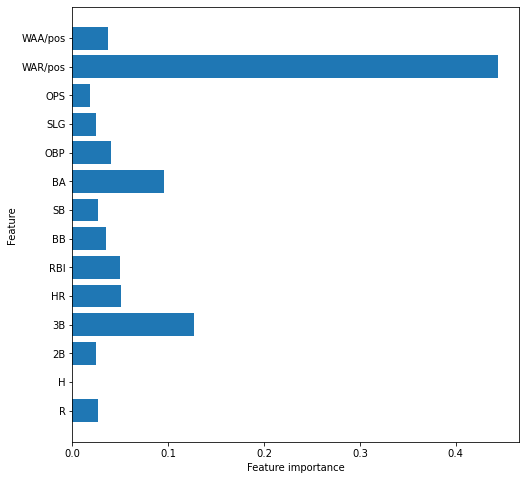

In [35]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(tree_clf)

Let's see how well our single decision tree model fared

In [36]:
# Test set predictions
pred = tree_clf.predict(X_test)

# Confusion matrix and classification report
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))
print("Testing Accuracy for Decision Tree Classifier: {:.4}%".format(accuracy_score(y_test, pred) * 100))

[[202  16]
 [  8  25]]
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       218
           1       0.61      0.76      0.68        33

    accuracy                           0.90       251
   macro avg       0.79      0.84      0.81       251
weighted avg       0.92      0.90      0.91       251

Testing Accuracy for Decision Tree Classifier: 90.44%


Let's try a grid search to see if there are better parameters for the decision tree classifier.

In [37]:
from sklearn.model_selection import GridSearchCV

Now we want to look at a random forest classifier.

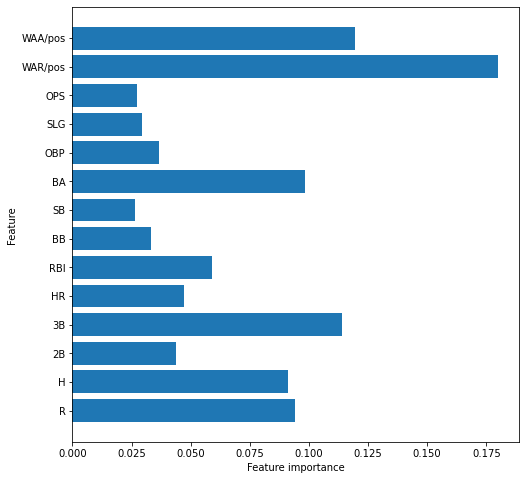

In [38]:
forest = RandomForestClassifier()
forest.fit(X_train, np.ravel(y_train))
plot_feature_importances(forest)

Let's see how this new random forest model fared

In [39]:
preds = forest.predict(X_test)
print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds))
print("Testing Accuracy for Random Forest Classifier: {:.4}%".format(accuracy_score(y_test, preds) * 100))

[[213   5]
 [  8  25]]
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       218
           1       0.83      0.76      0.79        33

    accuracy                           0.95       251
   macro avg       0.90      0.87      0.88       251
weighted avg       0.95      0.95      0.95       251

Testing Accuracy for Random Forest Classifier: 94.82%


In [40]:
param_grid = {
    'max_depth': [2, 5, 10, 25],
    'min_samples_split': [2, 5, 10, 20]
}

gs_tree = GridSearchCV(forest, param_grid, cv=3)
gs_tree.fit(X_train, np.ravel(y_train))

gs_tree.best_params_

{'max_depth': 10, 'min_samples_split': 5}

In [41]:
forest = RandomForestClassifier(max_depth=5, min_samples_split=2)
forest.fit(X_train, np.ravel(y_train))
preds = forest.predict(X_test)
print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds))
print("Testing Accuracy for Random Forest Classifier: {:.4}%".format(accuracy_score(y_test, preds) * 100))

[[210   8]
 [  5  28]]
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       218
           1       0.78      0.85      0.81        33

    accuracy                           0.95       251
   macro avg       0.88      0.91      0.89       251
weighted avg       0.95      0.95      0.95       251

Testing Accuracy for Random Forest Classifier: 94.82%


## XGBoost Model

In [42]:
from xgboost import XGBClassifier

In [43]:
# Instantiate XGBClassifier
xgb = XGBClassifier()

# Fit XGBClassifier
xgb.fit(X_train, np.ravel(y_train))

# Predict on training and test sets
training_preds = xgb.predict(X_train)
test_preds = xgb.predict(X_test)

# Accuracy of training and test sets
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

Training Accuracy: 100.0%
Validation accuracy: 95.62%


In [44]:
param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [6],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
}

grid_clf = GridSearchCV(xgb, param_grid, scoring='accuracy')
grid_clf.fit(X_train, np.ravel(y_train))

best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
test_preds = grid_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

Grid Search found the following optimal parameters: 
learning_rate: 0.2
max_depth: 6
min_child_weight: 1
n_estimators: 100
subsample: 0.5

Training Accuracy: 99.87%
Validation accuracy: 94.82%


In [45]:
print(confusion_matrix(y_test, test_preds))
print(classification_report(y_test, test_preds))
print("Testing Accuracy for XGBoost: {:.4}%".format(accuracy_score(y_test, test_preds) * 100))

[[212   6]
 [  7  26]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       218
           1       0.81      0.79      0.80        33

    accuracy                           0.95       251
   macro avg       0.89      0.88      0.89       251
weighted avg       0.95      0.95      0.95       251

Testing Accuracy for XGBoost: 94.82%


## SVM

In [46]:
from sklearn.svm import SVC

svc = SVC(kernel='poly')
svc.fit(X_train, np.ravel(y_train))
y_pred = svc.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Testing Accuracy for SVM Classifier: {:.4}%".format(accuracy_score(y_test, y_pred) * 100))

[[212   6]
 [ 12  21]]
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       218
           1       0.78      0.64      0.70        33

    accuracy                           0.93       251
   macro avg       0.86      0.80      0.83       251
weighted avg       0.92      0.93      0.93       251

Testing Accuracy for SVM Classifier: 92.83%


# Interpreting Data

So far the random forest classifier has been the best.

Now, we want to see how many active players are on track to be in the hall of fame by looking at their total counting stats (if a player  is younger than 36 (average retirement age for all players modeled), take the player's per-game stats and extrapolate it to  36 years old).

In [47]:
# get the average retirement age for each hall of fame player
import math
avg_retire_age = all_df['Age']
avg_retire_age = [int(row[-2:]) for row in avg_retire_age]
avg_retire_age = np.mean(avg_retire_age)

# round up to nearest whole number
avg_retire_age = math.ceil(avg_retire_age)
avg_retire_age

36

In [48]:
active_df

,Player,From,To,Age,G,PA,AB,R,H,2B,3B,HR,RBI,BA,OBP,SLG,OPS,SB,BB,SO,WAR/pos,WAA/pos,HBP,Pos,Tm,HOF
0,Albert Pujols,2001,2020,21-40,2862,12394,10839,1843,3236,669,16,662,2100,0.299,0.377,0.546,0.924,114,1331,1304,100.7,61.6,108,*3D75/9H64,STL-LAA,0
1,Miguel Cabrera,2003,2020,20-37,2457,10467,9153,1457,2866,581,17,487,1729,0.313,0.391,0.540,0.931,39,1159,1812,69.6,34.6,64,35D79/H,FLA-DET,0
2,Edwin Encarnacion,2005,2020,22-37,1960,8126,7040,1099,1832,370,10,424,1261,0.260,0.350,0.496,0.846,61,903,1426,35.7,8.5,105,D53/H74,CIN-TOR-CLE-SEA-NYY-CHW,0
3,Nelson Cruz,2005,2020,24-39,1742,7153,6397,952,1777,330,13,417,1152,0.278,0.347,0.529,0.876,76,632,1625,39.7,14.6,73,*9D7/H8,MIL-TEX-BAL-SEA-MIN,0
4,Ryan Braun,2007,2020,23-36,1766,7340,6622,1080,1963,408,49,352,1154,0.296,0.358,0.532,0.891,216,586,1363,46.9,24.4,77,*795/HD38,MIL,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,José Iglesias,2011,2020,21-30,841,3065,2848,325,792,163,12,35,271,0.278,0.319,0.381,0.700,52,135,371,12.4,2.0,44,*6/5HD4,BOS-DET-CIN-BAL,0
130,Tommy La Stella,2014,2020,25-31,531,1496,1316,164,360,72,4,31,163,0.274,0.349,0.405,0.754,5,143,159,4.4,-0.5,13,4H5/D31,ATL-CHC-LAA-OAK,0
131,Jeff McNeil,2018,2020,26-28,248,1024,918,137,293,63,7,30,117,0.319,0.383,0.501,0.884,12,69,123,9.4,6.2,29,4/795HD,NYM,0
132,Brock Holt,2012,2020,24-32,675,2401,2132,295,572,114,16,23,211,0.268,0.337,0.369,0.707,36,210,459,7.9,-0.2,23,457/H9638D1,PIT-BOS-WSN-MIL,0


In [49]:
# create a copy of all active players (this will be used for extrapolation)
test_df = active_df.copy()

# calculate total years played and current age
test_df['years_played'] = test_df['To'] - test_df['From']
test_df['current_age'] = [int(row[-2:]) for row in test_df['Age']]

# list of stats that will be estimated
est_stats = ['G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'BB', 'SB', 'WAR/pos', 'WAA/pos']

# loop through each stat and apply function, in this case, take average yearly stats for a player multiply by how many
# years left a player has until 36 years old, then add that onto the player's current career stats
for stat in est_stats:
    test_df[stat] = test_df[stat] + (test_df[stat] / test_df['years_played']) * (avg_retire_age - test_df['current_age'])
for row in test_df.index:
    if test_df.iloc[row]['current_age'] > avg_retire_age:
        test_df.loc[row] = active_df.loc[row]

In [50]:
test_df

,Player,From,To,Age,G,PA,AB,R,H,2B,3B,HR,RBI,BA,OBP,SLG,OPS,SB,BB,SO,WAR/pos,WAA/pos,HBP,Pos,Tm,HOF,years_played,current_age
0,Albert Pujols,2001,2020,21-40,2862.000000,12394,10839.000000,1843.000000,3236.000000,669.000000,16.000000,662.000000,2100.000000,0.299,0.377,0.546,0.924,114.000000,1331.000000,1304,100.700000,61.600000,108,*3D75/9H64,STL-LAA,0,NaN,NaN
1,Miguel Cabrera,2003,2020,20-37,2457.000000,10467,9153.000000,1457.000000,2866.000000,581.000000,17.000000,487.000000,1729.000000,0.313,0.391,0.540,0.931,39.000000,1159.000000,1812,69.600000,34.600000,64,35D79/H,FLA-DET,0,NaN,NaN
2,Edwin Encarnacion,2005,2020,22-37,1960.000000,8126,7040.000000,1099.000000,1832.000000,370.000000,10.000000,424.000000,1261.000000,0.260,0.350,0.496,0.846,61.000000,903.000000,1426,35.700000,8.500000,105,D53/H74,CIN-TOR-CLE-SEA-NYY-CHW,0,NaN,NaN
3,Nelson Cruz,2005,2020,24-39,1742.000000,7153,6397.000000,952.000000,1777.000000,330.000000,13.000000,417.000000,1152.000000,0.278,0.347,0.529,0.876,76.000000,632.000000,1625,39.700000,14.600000,73,*9D7/H8,MIL-TEX-BAL-SEA-MIN,0,NaN,NaN
4,Ryan Braun,2007,2020,23-36,1766.000000,7340,6622.000000,1080.000000,1963.000000,408.000000,49.000000,352.000000,1154.000000,0.296,0.358,0.532,0.891,216.000000,586.000000,1363,46.900000,24.400000,77,*795/HD38,MIL,0,13.0,36.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,José Iglesias,2011,2020,21-30,1401.666667,3065,4746.666667,541.666667,1320.000000,271.666667,20.000000,58.333333,451.666667,0.278,0.319,0.381,0.700,86.666667,225.000000,371,20.666667,3.333333,44,*6/5HD4,BOS-DET-CIN-BAL,0,9.0,30.0
130,Tommy La Stella,2014,2020,25-31,973.500000,1496,2412.666667,300.666667,660.000000,132.000000,7.333333,56.833333,298.833333,0.274,0.349,0.405,0.754,9.166667,262.166667,159,8.066667,-0.916667,13,4H5/D31,ATL-CHC-LAA-OAK,0,6.0,31.0
131,Jeff McNeil,2018,2020,26-28,1240.000000,1024,4590.000000,685.000000,1465.000000,315.000000,35.000000,150.000000,585.000000,0.319,0.383,0.501,0.884,60.000000,345.000000,123,47.000000,31.000000,29,4/795HD,NYM,0,2.0,28.0
132,Brock Holt,2012,2020,24-32,1012.500000,2401,3198.000000,442.500000,858.000000,171.000000,24.000000,34.500000,316.500000,0.268,0.337,0.369,0.707,54.000000,315.000000,459,11.850000,-0.300000,23,457/H9638D1,PIT-BOS-WSN-MIL,0,8.0,32.0


In [51]:
# Get predictions
test_pred = forest.predict(test_df[predictors])

The chart below shows all the active players that the model predicted to be hall-of-famers when using their extrapolated career stats.

In [52]:
test_df['HOF_pred'] = test_pred
test_df.loc[test_df['HOF_pred'] == 1]

,Player,From,To,Age,G,PA,AB,R,H,2B,3B,HR,RBI,BA,OBP,SLG,OPS,SB,BB,SO,WAR/pos,WAA/pos,HBP,Pos,Tm,HOF,years_played,current_age,HOF_pred
10,Mike Trout,2011,2020,19-28,2364.888889,5514,8573.666667,1783.111111,2606.666667,491.111111,90.666667,570.444444,1507.333333,0.304,0.418,0.582,1.000,379.666667,1582.888889,1174,140.911111,106.344444,84,*87/D9H,LAA,0,9.0,28.0,1
19,Nolan Arenado,2013,2020,22-29,2158.000000,4558,8236.000000,1298.000000,2412.000000,524.000000,54.000000,470.000000,1520.000000,0.293,0.349,0.541,0.890,32.000000,724.000000,684,78.200000,49.800000,22,*5/HD,COL,0,7.0,29.0,1
21,Bryce Harper,2012,2020,19-27,2426.750000,4883,8646.625000,1591.625000,2384.250000,484.500000,44.625000,493.000000,1419.500000,0.276,0.387,0.513,0.900,208.250000,1557.625000,1055,71.612500,39.525000,31,*978/HD3,WSN-PHI,0,8.0,27.0,1
24,Manny Machado,2012,2020,19-27,2426.750000,4989,9628.375000,1374.875000,2694.500000,518.500000,31.875000,473.875000,1370.625000,0.280,0.337,0.488,0.825,136.000000,822.375000,834,84.575000,49.725000,21,*56/DH,BAL-LAD-SDP,0,8.0,27.0,1
43,Mookie Betts,2014,2020,21-27,2122.500000,3875,8555.000000,1650.000000,2572.500000,595.000000,67.500000,387.500000,1272.500000,0.301,0.373,0.522,0.895,340.000000,987.500000,502,113.500000,82.750000,21,*98/4DH,BOS-LAD,0,6.0,27.0,1
46,Christian Yelich,2013,2020,21-28,2095.714286,4290,8016.428571,1341.428571,2374.285714,462.857143,53.571429,323.571429,1118.571429,0.296,0.381,0.488,0.870,274.285714,1058.571429,908,69.214286,41.571429,32,*789/HD,MIA-MIL,0,7.0,28.0,1
57,Francisco Lindor,2015,2020,21-26,2331.000000,3510,9420.000000,1524.000000,2688.000000,573.000000,45.000000,414.000000,1233.000000,0.285,0.346,0.488,0.833,297.000000,852.000000,496,86.100000,51.900000,25,*6/DH,CLE,0,5.0,26.0,1
60,Trevor Story,2016,2020,23-27,1959.750000,2541,7462.000000,1218.750000,2067.000000,474.500000,71.500000,435.500000,1218.750000,0.277,0.343,0.535,0.877,260.000000,692.250000,726,68.250000,42.575000,21,*6/HD,COL,0,4.0,27.0,1
61,Jose Altuve,2011,2020,21-30,2151.666667,5668,8628.333333,1276.666667,2683.333333,513.333333,46.666667,221.666667,926.666667,0.311,0.361,0.458,0.819,426.666667,628.333333,662,60.833333,29.833333,50,*4/DH6,HOU,0,9.0,30.0,1
72,Cody Bellinger,2017,2020,21-24,2530.000000,2084,9040.000000,1625.000000,2470.000000,490.000000,70.000000,615.000000,1590.000000,0.273,0.364,0.547,0.911,225.000000,1290.000000,447,94.500000,62.000000,7,*389/7HD,LAD,0,3.0,24.0,1


I want to take a moment to go over some background information on voting in hall of famers. 
- To be eligible, the player must have began his career at least 20 years before, and ended his career 5 years before the voting year
- A player is allowed to be on the ballot for at most 10 years. Players who are "obviously" hall of famers will get in on the first year of their eligibility, while players who are probable, but not transcendent, will likely take a few years before getting voted in. 

The issue with this model so far is that it labels (1) players who are first-ballot hall of famers but have not gotten in solely because they have not been retired for the 5-year minimum, (2) players who would be first-ballot hall of famers if they retired today, as non-hall-of-famers, and (3) players who have the statistics to get in, but are hindered by other reasons (controversy, steroids, etc.). So while these players have the career stats that would grant them first-ballot hall of fame status, they are not for eligibility reasons. Yet, this model is supposed to predict based on statistics only and having these players labeled as non-hall-of-famers will likely hurt the model.

**First-ballot** means that the player would be voted into the hall of fame on the first-year of eligibility 

So one thing to do that could help with the predictions is to artificially label these players as hall-of-famers. I only included predicted first-ballot hall of famers and not all predicted hall of famers, because they are generally unanimously agreed as hall of fame worthy. 

First-ballot hall-of-famer predictions will be supplied by: https://www.espn.com/mlb/story/_/id/28516610/predicting-mlb-hall-fame-selections-2020s
* only projected first-ballot hall of famers are included

This article mentions some players who were implicated for using steroids but should still be included in the hall-of-fame: https://bleacherreport.com/articles/2886512-which-mlb-steroid-users-deserve-to-be-in-the-baseball-hall-of-fame

In [53]:
hof_pred_df = all_df.copy()

In [54]:
# created aggregated list of names of players who will/should be hall of fame
wb_hall_of_fame = ['David Ortiz', 'Barry Bonds', 'Derek Jeter', 'Adrian Beltre', 'Ichiro Suzuki', 
                   'Albert Pujols', 'Miguel Cabrera']

# mark these players as "hall of famers"
for name in wb_hall_of_fame:
    hof_pred_df.loc[all_df['Player'] == name, 'HOF'] = 1

# create predictors and target for train test split
hof_predictors = hof_pred_df[predictors]
hof_pred_target = hof_pred_df['HOF']

X_train2, X_test2, y_train2, y_test2 = train_test_split(hof_predictors, hof_pred_target, test_size=.25, random_state=0)

In [55]:
# Instantiate XGBClassifier
xgb = XGBClassifier()

# Fit XGBClassifier
xgb.fit(X_train2, np.ravel(y_train2))

# Predict on training and test sets
training_preds = xgb.predict(X_train2)
test_preds = xgb.predict(X_test2)

# Accuracy of training and test sets
training_accuracy = accuracy_score(y_train2, training_preds)
test_accuracy = accuracy_score(y_test2, test_preds)

print(confusion_matrix(y_test, xgb.predict(X_test2)))
print(classification_report(y_test2, xgb.predict(X_test2)))

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

[[212   6]
 [  4  29]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       217
           1       0.83      0.85      0.84        34

    accuracy                           0.96       251
   macro avg       0.90      0.91      0.91       251
weighted avg       0.96      0.96      0.96       251

Training Accuracy: 100.0%
Validation accuracy: 95.62%


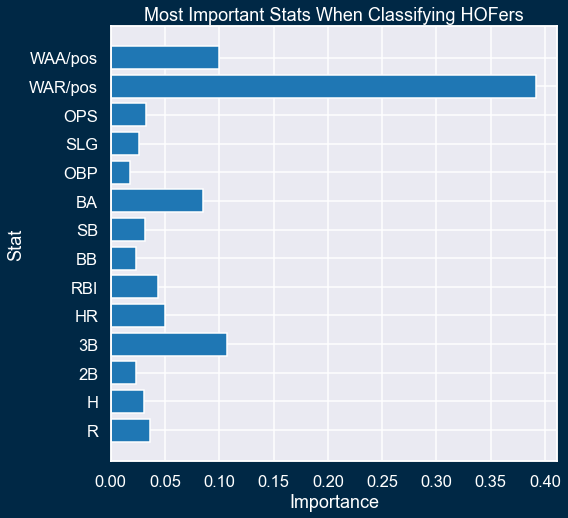

In [104]:
sns.set_context('talk')
fig = plt.figure(figsize=(8,8))
fig.patch.set_facecolor('#002845')
ax=plt.gca()
n_features = X_train.shape[1]
plt.barh(range(n_features), xgb.feature_importances_, align='center') 
plt.yticks(np.arange(n_features), X_train.columns.values) 
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
plt.tick_params(axis='both', colors='white')  
ax.set_title('Most Important Stats When Classifying HOFers', color='white')
plt.ylabel('Stat')
plt.xlabel('Importance')
#plt.savefig('stat_plot', bbox_inches='tight')

In [1010]:
# try different parameters for XGBoost
param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [6],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
}

grid_clf = GridSearchCV(xgb, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_clf.fit(X_train, np.ravel(y_train))

best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
test_preds = grid_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

Grid Search found the following optimal parameters: 
learning_rate: 0.2
max_depth: 6
min_child_weight: 1
n_estimators: 100
subsample: 0.5

Training Accuracy: 99.87%
Validation accuracy: 94.82%


In [1011]:
knn_hof = KNeighborsClassifier()
knn_hof.fit(X_train2, y_train2)

print(confusion_matrix(y_test, knn.predict(X_test2)))
print(classification_report(y_test2, knn_hof.predict(X_test2)))
print("Testing Accuracy for K-Neighbors Classifier: {:.4}%".format(accuracy_score(y_test2, 
                                                                                  knn_hof.predict(X_test2)) * 100))

[[209   9]
 [  7  26]]
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       217
           1       0.77      0.79      0.78        34

    accuracy                           0.94       251
   macro avg       0.87      0.88      0.87       251
weighted avg       0.94      0.94      0.94       251

Testing Accuracy for K-Neighbors Classifier: 94.02%


Based on the results from the tested models, I am sticking with the XGBoost without parameters.

In [1012]:
# make predictions using the chosen model
pred_df2 = test_df.copy()
hof_pred = xgb.predict(pred_df2[predictors])

# show all active players who are projected hall of famers
pred_df2['HOF_pred'] = hof_pred
pred_df2.loc[pred_df2['HOF_pred'] == 1]

,Player,From,To,Age,G,PA,AB,R,H,2B,3B,HR,RBI,BA,OBP,SLG,OPS,SB,BB,SO,WAR/pos,WAA/pos,HBP,Pos,Tm,HOF,years_played,current_age,HOF_pred
0,Albert Pujols,2001,2020,21-40,2862.000000,12394,10839.000000,1843.000000,3236.000000,669.000000,16.000000,662.000000,2100.000000,0.299,0.377,0.546,0.924,114.000000,1331.000000,1304,100.700000,61.600000,108,*3D75/9H64,STL-LAA,0,NaN,NaN,1
10,Mike Trout,2011,2020,19-28,2364.888889,5514,8573.666667,1783.111111,2606.666667,491.111111,90.666667,570.444444,1507.333333,0.304,0.418,0.582,1.000,379.666667,1582.888889,1174,140.911111,106.344444,84,*87/D9H,LAA,0,9.0,28.0,1
19,Nolan Arenado,2013,2020,22-29,2158.000000,4558,8236.000000,1298.000000,2412.000000,524.000000,54.000000,470.000000,1520.000000,0.293,0.349,0.541,0.890,32.000000,724.000000,684,78.200000,49.800000,22,*5/HD,COL,0,7.0,29.0,1
21,Bryce Harper,2012,2020,19-27,2426.750000,4883,8646.625000,1591.625000,2384.250000,484.500000,44.625000,493.000000,1419.500000,0.276,0.387,0.513,0.900,208.250000,1557.625000,1055,71.612500,39.525000,31,*978/HD3,WSN-PHI,0,8.0,27.0,1
24,Manny Machado,2012,2020,19-27,2426.750000,4989,9628.375000,1374.875000,2694.500000,518.500000,31.875000,473.875000,1370.625000,0.280,0.337,0.488,0.825,136.000000,822.375000,834,84.575000,49.725000,21,*56/DH,BAL-LAD-SDP,0,8.0,27.0,1
43,Mookie Betts,2014,2020,21-27,2122.500000,3875,8555.000000,1650.000000,2572.500000,595.000000,67.500000,387.500000,1272.500000,0.301,0.373,0.522,0.895,340.000000,987.500000,502,113.500000,82.750000,21,*98/4DH,BOS-LAD,0,6.0,27.0,1
46,Christian Yelich,2013,2020,21-28,2095.714286,4290,8016.428571,1341.428571,2374.285714,462.857143,53.571429,323.571429,1118.571429,0.296,0.381,0.488,0.870,274.285714,1058.571429,908,69.214286,41.571429,32,*789/HD,MIA-MIL,0,7.0,28.0,1
57,Francisco Lindor,2015,2020,21-26,2331.000000,3510,9420.000000,1524.000000,2688.000000,573.000000,45.000000,414.000000,1233.000000,0.285,0.346,0.488,0.833,297.000000,852.000000,496,86.100000,51.900000,25,*6/DH,CLE,0,5.0,26.0,1
60,Trevor Story,2016,2020,23-27,1959.750000,2541,7462.000000,1218.750000,2067.000000,474.500000,71.500000,435.500000,1218.750000,0.277,0.343,0.535,0.877,260.000000,692.250000,726,68.250000,42.575000,21,*6/HD,COL,0,4.0,27.0,1
72,Cody Bellinger,2017,2020,21-24,2530.000000,2084,9040.000000,1625.000000,2470.000000,490.000000,70.000000,615.000000,1590.000000,0.273,0.364,0.547,0.911,225.000000,1290.000000,447,94.500000,62.000000,7,*389/7HD,LAD,0,3.0,24.0,1


Looking at current flagship PSA 10 rookie cards, we can aggregate all current rookie cards under \$100, as some of these players have already blown up in price. They are (average of last 3 eBay sales as of 2/11/2021):
- Trevor Story 2016 Topps Chrome: \$80.52
- Matt Chapman 2017 Topps: \$61.33
- Pete Alonso 2019 Topps: \$47.20
- Alex Bregman 2017 Topps: \$39.33

Next, we want to find the hall-of-fame players that are most "similar" and retreive the rookie card prices for those hall-of-fame players. Because the vintage market is different from the modern market, I am taking the player who has played most recently to act as the price comparison.

In [1013]:
# find player comparison for Trevor Story
story_df = hof_df.copy()
story_df2 = story_df[predictors]

# take Trevor Story's projected stats and subtract them from every hall of famer's
story_df2 = story_df2 - pred_df2.loc[pred_df2['Player'] == 'Trevor Story'][predictors].values.squeeze()
# take absolute value of new subtracted values
story_df2 = story_df2.abs()

# show top 10 players who have the lowest mean difference from Trevor Story's stats
story_df.loc[story_df2.mean(axis=1).sort_values().head(10).index]

,Player,From,To,Age,G,PA,AB,R,H,2B,3B,HR,RBI,BA,OBP,SLG,OPS,SB,BB,SO,WAR/pos,WAA/pos,HBP,Pos,Tm,HOF
99,Chuck Klein,1928,1944,23-39,1753,7172,6486,1168,2076,398,74,300,1201,0.320,0.379,0.543,0.922,79,601,521,46.0,22.9,12,*97H/83,CHC-PIT-PHI,1
172,Larry Walker,1989,2005,22-38,1988,8030,6907,1355,2160,471,62,383,1311,0.313,0.400,0.565,0.965,230,913,1231,72.7,48.3,138,*9H/387D45,MON-COL-STL,1
7,Earl Averill,1929,1941,27-39,1669,7221,6353,1224,2019,401,128,238,1164,0.318,0.395,0.534,0.928,70,774,518,51.1,25.9,33,*8/7H9,CLE-DET-BSN,1
159,Duke Snider,1947,1964,20-37,2143,8237,7161,1259,2116,358,85,407,1333,0.295,0.380,0.540,0.919,99,971,1237,66.0,34.9,21,*89H/7,BRO-LAD-NYM-SFG,1
16,Yogi Berra,1946,1965,21-40,2120,8364,7555,1175,2150,321,49,358,1430,0.285,0.348,0.482,0.830,30,704,414,59.5,34.1,52,*2H79/35,NYY-NYM,1
52,Bobby Doerr,1937,1951,19-33,1865,8030,7093,1094,2042,381,89,223,1247,0.288,0.362,0.461,0.823,54,809,608,51.1,26.8,11,*4/H,BOS,1
30,Gary Carter,1974,1992,20-38,2296,9019,7971,1025,2092,371,31,324,1225,0.262,0.335,0.439,0.773,39,848,997,70.1,40.1,68,*29H/375,MON-NYM-SFG-LAD,1
120,Johnny Mize,1936,1953,23-40,1884,7372,6443,1118,2011,367,83,359,1337,0.312,0.397,0.562,0.959,28,856,524,71.3,45.1,52,*3H/9,STL-NYG-NYY,1
131,Mike Piazza,1992,2007,23-38,1912,7745,6911,1048,2127,344,8,427,1335,0.308,0.377,0.545,0.922,17,759,1113,59.6,35.9,30,*2DH/3,LAD-FLA-NYM-SDP-OAK,1
58,Carlton Fisk,1969,1993,21-45,2499,9853,8756,1276,2356,421,47,376,1330,0.269,0.341,0.457,0.797,128,849,1386,68.4,35.3,143,*2DH/735,BOS-CHW,1


Here, the most recent player is Mike Piazza, who played from 1992-2007. The last three eBay sales of his 1992 Fleer PSA 10 Rookies are \\$440, \\$320.07, and \\$280, giving us an average of \$346.69.

This is merely speculation, but purchasing a Story rookie for \\$80.52 that appreciates to \$346.69 would net an ROI of 331%

Now, let's continue this same process with the other three players

In [1014]:
chapman_df = hof_df.copy()
chapman_df2 = chapman_df[predictors]

chapman_df2 = chapman_df2 - pred_df2.loc[pred_df2['Player'] == 'Matt Chapman'][predictors].values.squeeze()

chapman_df2 = chapman_df2.abs()

chapman_df.loc[chapman_df2.mean(axis=1).sort_values().head(10).index]

,Player,From,To,Age,G,PA,AB,R,H,2B,3B,HR,RBI,BA,OBP,SLG,OPS,SB,BB,SO,WAR/pos,WAA/pos,HBP,Pos,Tm,HOF
65,Joe Gordon,1938,1950,23-35,1566,6537,5707,914,1530,264,52,253,975,0.268,0.357,0.466,0.822,89,759,702,55.7,35.8,29,*4/3H6,NYY-CLE,1
38,Mickey Cochrane,1925,1937,22-34,1482,6211,5169,1041,1652,333,64,119,830,0.320,0.419,0.478,0.897,64,857,217,49.1,26.5,29,*2/H7,PHA-DET,1
68,Hank Greenberg,1930,1947,19-36,1394,6098,5193,1046,1628,379,71,331,1274,0.313,0.412,0.605,1.017,58,852,844,55.7,35.1,16,*37/H,DET-PIT,1
51,Larry Doby,1947,1959,23-35,1533,6302,5348,960,1515,243,52,253,970,0.283,0.386,0.490,0.876,47,871,1011,49.3,30.3,38,*89/H7436,CLE-CHW-DET,1
184,Hack Wilson,1923,1934,23-34,1348,5557,4760,884,1461,266,67,244,1063,0.307,0.395,0.545,0.940,52,674,713,38.2,20.7,20,*879/H4,NYG-CHC-BRO-PHI,1
142,Jackie Robinson,1947,1956,28-37,1382,5804,4877,947,1518,273,54,137,734,0.311,0.409,0.474,0.883,197,740,291,61.7,39.6,72,*4537/H69,BRO,1
20,Lou Boudreau,1938,1952,20-34,1646,7025,6029,861,1779,385,66,68,789,0.295,0.380,0.415,0.795,51,796,309,63.0,42.2,34,*6/5H324,CLE-BOS,1
98,Ralph Kiner,1946,1955,23-32,1472,6256,5205,971,1451,216,39,369,1015,0.279,0.398,0.548,0.946,22,1011,749,47.9,24.3,24,*7/83H,PIT-CHC-CLE,1
75,Gabby Hartnett,1922,1941,21-40,1990,7300,6432,867,1912,396,64,236,1179,0.297,0.370,0.489,0.858,28,703,697,56.9,33.1,35,*2H/3,CHC-NYG,1
49,Bill Dickey,1928,1946,21-39,1789,7065,6300,930,1969,343,72,202,1209,0.313,0.382,0.486,0.868,36,678,289,57.3,33.0,31,*2H,NYY,1


Chapman is a little difficult to predict as most of his player comparisons are older players, and the vintage market pricing structure is much more different than modern cards. Since the original goal was to provide three player recommendations, let's see if the other two players give us better comparisons. If not, we will come back to Chapman.

In [1015]:
alonso_df = hof_df.copy()
alonso_df2 = alonso_df[predictors]

alonso_df2 = alonso_df2 - pred_df2.loc[pred_df2['Player'] == 'Pete Alonso'][predictors].values.squeeze()

alonso_df2 = alonso_df2.abs()

alonso_df.loc[alonso_df2.mean(axis=1).sort_values().head(10).index]

,Player,From,To,Age,G,PA,AB,R,H,2B,3B,HR,RBI,BA,OBP,SLG,OPS,SB,BB,SO,WAR/pos,WAA/pos,HBP,Pos,Tm,HOF
69,Ken Griffey Jr.,1989,2010,19-40,2671,11304,9801,1662,2781,524,38,630,1836,0.284,0.370,0.538,0.907,184,1312,1779,83.8,46.8,81,*89DH/73,SEA-CIN-CHW,1
82,Reggie Jackson,1967,1987,21-41,2820,11418,9864,1551,2584,463,49,563,1702,0.262,0.356,0.490,0.846,228,1375,2597,74.0,35.4,96,*9D8H/7,KCA-OAK-BAL-NYY-CAL,1
164,Jim Thome,1991,2012,20-41,2543,10313,8422,1583,2328,451,26,612,1699,0.276,0.402,0.554,0.956,19,1747,2548,72.9,37.6,69,3D5H,CLE-CHW-LAD-MIN-BAL-PHI,1
163,Frank Thomas,1990,2008,22-40,2322,10075,8199,1494,2468,495,12,521,1704,0.301,0.419,0.555,0.974,32,1667,1397,73.8,39.3,87,*D3/H,CHW-TOR-OAK,1
61,Jimmie Foxx,1925,1945,17-37,2317,9677,8134,1751,2646,458,125,534,1922,0.325,0.428,0.609,1.038,87,1452,1311,93.1,59.9,13,*3H52/7916,PHA-BOS-CHC-PHI,1
8,Jeff Bagwell,1991,2005,23-37,2150,9431,7797,1517,2314,488,32,449,1529,0.297,0.408,0.540,0.948,202,1401,1558,79.9,52.0,128,*3/HD9,HOU,1
111,Eddie Mathews,1952,1968,20-36,2391,10101,8537,1509,2315,354,72,512,1453,0.271,0.376,0.509,0.885,68,1444,1487,96.2,58.4,26,*53/H7,BSN-MLN-ATL-HOU-DET,1
151,Mike Schmidt,1972,1989,22-39,2404,10062,8352,1506,2234,408,59,548,1595,0.267,0.380,0.527,0.908,174,1507,1883,106.9,73.7,79,*53/H64,PHI,1
12,Ernie Banks,1953,1971,22-40,2528,10396,9421,1305,2583,407,90,512,1636,0.274,0.330,0.500,0.830,50,763,1236,67.8,28.8,70,36/H57,CHC,1
181,Billy Williams,1959,1976,21-38,2488,10519,9350,1410,2711,434,88,426,1475,0.290,0.361,0.492,0.853,90,1045,1046,63.7,27.1,43,*79D/3H8,CHC-OAK,1


Here, the most recent player is Jim Thome, who was actually a very similar type of player of Pete Alonso. Thome's last three 1991 Bowman PSA 10 sales are \\$169.99, \\$90, and \\$145.50, giving us an average of \\$135.16, and an Alonso rookie bought at \\$47.50 that appreciates to \\$135.16 gives an ROI of 185%

In [1016]:
bregman_df = hof_df.copy()
bregman_df2 = bregman_df[predictors]

bregman_df2 = bregman_df2 - pred_df2.loc[pred_df2['Player'] == 'Alex Bregman'][predictors].values.squeeze()

bregman_df2 = bregman_df2.abs()

bregman_df.loc[bregman_df2.mean(axis=1).sort_values().head(10).index]

,Player,From,To,Age,G,PA,AB,R,H,2B,3B,HR,RBI,BA,OBP,SLG,OPS,SB,BB,SO,WAR/pos,WAA/pos,HBP,Pos,Tm,HOF
159,Duke Snider,1947,1964,20-37,2143,8237,7161,1259,2116,358,85,407,1333,0.295,0.380,0.540,0.919,99,971,1237,66.0,34.9,21,*89H/7,BRO-LAD-NYM-SFG,1
172,Larry Walker,1989,2005,22-38,1988,8030,6907,1355,2160,471,62,383,1311,0.313,0.400,0.565,0.965,230,913,1231,72.7,48.3,138,*9H/387D45,MON-COL-STL,1
110,Edgar Martinez,1987,2004,24-41,2055,8674,7213,1219,2247,514,15,309,1261,0.312,0.418,0.515,0.933,49,1283,1202,68.4,38.5,89,*D5/H3,SEA,1
14,Johnny Bench,1967,1983,19-35,2158,8674,7658,1091,2048,381,24,389,1376,0.267,0.342,0.476,0.817,68,891,1278,75.2,46.7,19,*253H/798,CIN,1
149,Ron Santo,1960,1974,20-34,2243,9397,8143,1138,2254,365,67,342,1331,0.277,0.362,0.464,0.826,35,1108,1343,70.5,36.8,38,*5/D4H673,CHC-CHW,1
58,Carlton Fisk,1969,1993,21-45,2499,9853,8756,1276,2356,421,47,376,1330,0.269,0.341,0.457,0.797,128,849,1386,68.4,35.3,143,*2DH/735,BOS-CHW,1
7,Earl Averill,1929,1941,27-39,1669,7221,6353,1224,2019,401,128,238,1164,0.318,0.395,0.534,0.928,70,774,518,51.1,25.9,33,*8/7H9,CLE-DET-BSN,1
120,Johnny Mize,1936,1953,23-40,1884,7372,6443,1118,2011,367,83,359,1337,0.312,0.397,0.562,0.959,28,856,524,71.3,45.1,52,*3H/9,STL-NYG-NYY,1
30,Gary Carter,1974,1992,20-38,2296,9019,7971,1025,2092,371,31,324,1225,0.262,0.335,0.439,0.773,39,848,997,70.1,40.1,68,*29H/375,MON-NYM-SFG-LAD,1
44,Joe Cronin,1926,1945,19-38,2124,8840,7579,1233,2285,515,118,170,1424,0.301,0.390,0.468,0.857,87,1059,700,64.1,33.6,34,*6H/5347,PIT-WSH-BOS,1


Here, the most recent player is Larry Walker. His last three 1990 Leaf PSA 10 rookies sold for \\$135, \\$132, and \\$130, giving us an average of \\$132.33. A Bregman rookie purchased at \\$39.33 that increased to \\$132.33 would net an ROI of 236%

# Future Work

Some areas of interest in the future are:
1) **Modeling on per-162 game data**: An MLB season is usually 162 games long and per-162 game data projects a player's stats if that player had played every single game in the season. Using this data instead of career data could provide more insight on possible buys.

2) **Era-based modeling**: The game of baseball has changed a lot of time and with that, the statistics of a "good" player has also changed. For example, very early baseball was not a homerun-heavy sport. Frank "Home Run" Baker, who player in the early 1900's and was given that nickname because he hit a lot of home runs, never hit more than 12 in a season. In 2019, 58 players hit 30 or more home runs that season. Including only players after the expansion era (ended 1973) could provide a more accurate measure of what is needed for a player to reach the hall of fame today. The only problem would be lack of data points, but using SMOTE to artificially generate data should do the trick.

3) **Pitcher model**: Generating a simliar methodolgy for pitchers would also be an interesting challege. The only issue here is that pitchers traditionally do not command as much money as batters in the sports card market. In general, I would not consider pitchers to be good investments.